<a href="https://colab.research.google.com/github/sizhky/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter09/Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('PennFudanPed'):
    !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
    !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
    !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
    !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
    !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
    !pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' torch_snippets
    !wget --quiet https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
    !unzip -q PennFudanPed.zip
    !rm PennFudanPed.zip

In [ ]:
from torch_snippets import *
import os
import numpy as np
import torch
from PIL import Image

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 36.7MB 76kB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=90a3f567331d7754275d140496c10d3beb083ba9c1be4446ce49937cfc0cd933
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars


In [ ]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        # ignore pixels which are class 0
        obj_ids = obj_ids[1:]

        # convert a single mask of integer pixel values into
        # a set of binary masks, each mask corresponding to one
        # instance. E.g., convert 
        # [[0,0,1],
        # [1,1,2],
        # [1,2,2]]
        # to (instance 1)
        # [[0,0,1],
        # [1,1,0],
        # [1,0,0]]
        # and (instance 2)
        # [[0,0,0],
        # [0,0,1],
        # [0,1,1]]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
num_epochs = 5

trn_history = []
val_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)
    val_history.append(res)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/60]  eta: 0:01:30  lr: 0.000090  loss: 4.1355 (4.1355)  loss_classifier: 0.7415 (0.7415)  loss_box_reg: 0.2235 (0.2235)  loss_mask: 3.1406 (3.1406)  loss_objectness: 0.0161 (0.0161)  loss_rpn_box_reg: 0.0139 (0.0139)  time: 1.5128  data: 0.0796  max mem: 2583
Epoch: [0]  [10/60]  eta: 0:00:24  lr: 0.000936  loss: 1.7542 (2.2891)  loss_classifier: 0.4692 (0.4704)  loss_box_reg: 0.2045 (0.2393)  loss_mask: 0.9911 (1.5546)  loss_objectness: 0.0161 (0.0194)  loss_rpn_box_reg: 0.0039 (0.0055)  time: 0.4862  data: 0.0518  max mem: 2740
Epoch: [0]  [20/60]  eta: 0:00:18  lr: 0.001783  loss: 0.8871 (1.5436)  loss_classifier: 0.2148 (0.3396)  loss_box_reg: 0.2062 (0.2496)  loss_mask: 0.3699 (0.9314)  loss_objectness: 0.0129 (0.0166)  loss_rpn_box_reg: 0.0040 (0.0063)  time: 0.4081  data: 0.0605  max mem: 2860
Epoch: [0]  [30/60]  eta: 0:00:13  lr: 0.002629  loss: 0.5787 (1.2170)  loss_classifier: 0.1147 (0.2567)  loss_box_reg: 0.2116 (0.2390)  loss_mask: 0.2224 (0.7012)  loss_ob

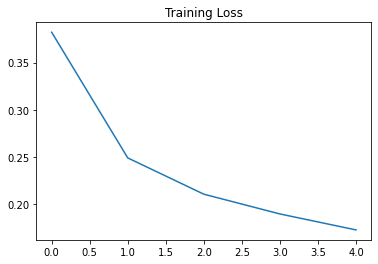

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
training_losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
# validation_losses = [np.mean(list(val_history[i].meters['loss'].deque)) for i in range(len(val_history))]
plt.plot(training_losses,label='Training loss')
# plt.plot(validation_losses, label='Validation loss')

In [ ]:
dataset_test[0][0].shape

torch.Size([3, 364, 371])

In [ ]:
model.eval()
with torch.no_grad():
    prediction = model([dataset_test[0][0].to(device)])

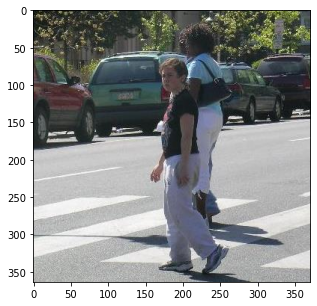

In [ ]:
show(dataset_test[0][0],sz=5, grid=True)

In [ ]:
prediction

[{'boxes': tensor([[157.4260,  57.2530, 255.3829, 358.2980],
          [200.4447,  23.6282, 267.3466, 285.8848]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9941, 0.8844], device='cuda:0')}]

In [ ]:
prediction[0]['labels']

tensor([1, 1], device='cuda:0')

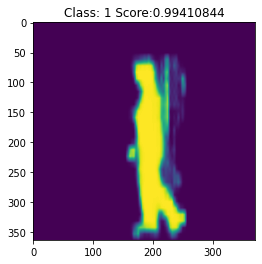

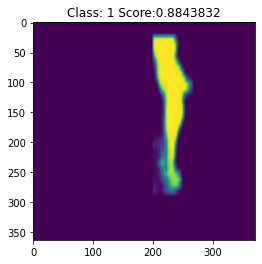

In [ ]:
model.eval()
with torch.no_grad():
    prediction = model([dataset_test[0][0].to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

In [ ]:
!wget https://www.dropbox.com/s/e92sui3a4ktvb4j/Hema18.JPG

--2020-10-12 05:00:15--  https://www.dropbox.com/s/e92sui3a4ktvb4j/Hema18.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/e92sui3a4ktvb4j/Hema18.JPG [following]
--2020-10-12 05:00:16--  https://www.dropbox.com/s/raw/e92sui3a4ktvb4j/Hema18.JPG
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5714ca34b795f7485ffc6ad41f.dl.dropboxusercontent.com/cd/0/inline/BBF-usA5TGh1jorbHCpx_Vu5CiF1hHwv-YuyBnDa_V9ayHIOL_EF2kqokTFHa6b_p_pcg3UKCCImFXtsts5UIrgvnD72EnuEbu96gjUWOuG-CxBY-p1sQSSdxF9HipV-Jd0/file# [following]
--2020-10-12 05:00:16--  https://uc5714ca34b795f7485ffc6ad41f.dl.dropboxusercontent.com/cd/0/inline/BBF-usA5TGh1jorbHCpx_Vu5CiF1hHwv-YuyBnDa_V9ayHIOL_EF2kqokTFHa6b_p_pcg3UKCCImFXtsts5UIrgvnD72EnuEbu96gjUWOuG-CxBY-p1sQ

In [ ]:
img = read('Hema18.JPG',1)

In [ ]:
img = Image.open('Hema18.JPG').convert("RGB")

In [ ]:
from torchvision import transforms
pil_to_tensor = transforms.ToTensor()(img).unsqueeze_(0)
print(pil_to_tensor.shape) 

torch.Size([1, 3, 310, 208])


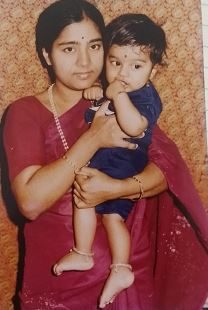

In [ ]:
#img, _ = dataset_test[np.random.randint(len(dataset_test))]
Image.fromarray(pil_to_tensor[0].mul(255).permute(1, 2, 0).byte().numpy())

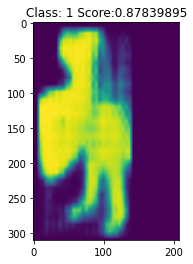

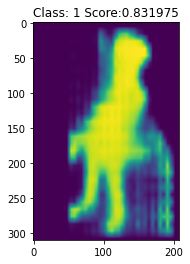

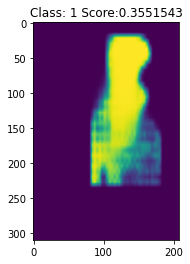

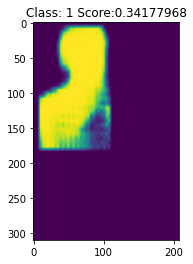

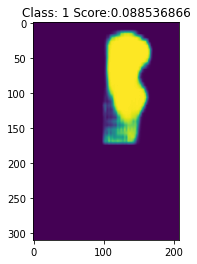

In [ ]:
model.eval()
with torch.no_grad():
    prediction = model([pil_to_tensor[0].to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

In [ ]:
len(prediction[0]['masks'])

3